# Image segmentation with a U-Net-like architecture

**Author:** [fchollet](https://twitter.com/fchollet)<br>
**Date created:** 2019/03/20<br>
**Last modified:** 2020/04/20<br>
**Description:** Image segmentation model trained from scratch on the Oxford Pets dataset.

## Download the data

In [1]:
!curl -O https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz
!curl -O https://thor.robots.ox.ac.uk/~vgg/data/pets/annotations.tar.gz
!tar -xf images.tar.gz
!tar -xf annotations.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  755M  100  755M    0     0  28.4M      0  0:00:26  0:00:26 --:--:-- 30.1M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 18.2M  100 18.2M    0     0  10.9M      0  0:00:01  0:00:01 --:--:-- 10.9M


In [ ]:
#!curl -O https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
#!curl -O https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
#!tar -xf images.tar.gz
#!tar -xf annotations.tar.gz

## Prepare paths of input images and target segmentation masks

In [2]:
import os

input_dir = "images/"
target_dir = "annotations/trimaps/"
img_size = (160, 160)
num_classes = 3
batch_size = 32

input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".jpg")
    ]
)
target_img_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

print("Number of samples:", len(input_img_paths))

for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
    print(input_path, "|", target_path)

Number of samples: 7390
images/Abyssinian_1.jpg | annotations/trimaps/Abyssinian_1.png
images/Abyssinian_10.jpg | annotations/trimaps/Abyssinian_10.png
images/Abyssinian_100.jpg | annotations/trimaps/Abyssinian_100.png
images/Abyssinian_101.jpg | annotations/trimaps/Abyssinian_101.png
images/Abyssinian_102.jpg | annotations/trimaps/Abyssinian_102.png
images/Abyssinian_103.jpg | annotations/trimaps/Abyssinian_103.png
images/Abyssinian_104.jpg | annotations/trimaps/Abyssinian_104.png
images/Abyssinian_105.jpg | annotations/trimaps/Abyssinian_105.png
images/Abyssinian_106.jpg | annotations/trimaps/Abyssinian_106.png
images/Abyssinian_107.jpg | annotations/trimaps/Abyssinian_107.png


## What does one input image and corresponding segmentation mask look like?

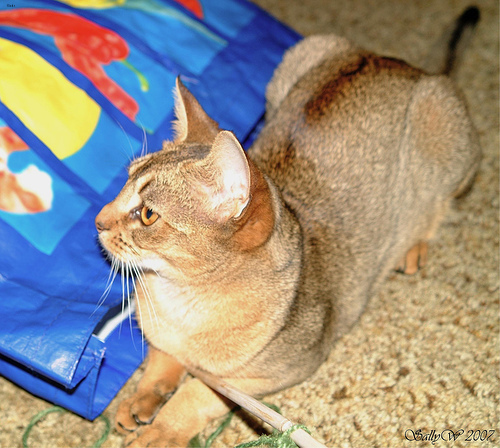

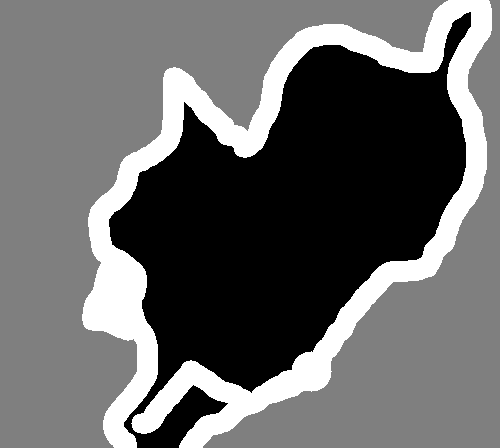

In [3]:
from IPython.display import Image, display
from tensorflow.keras.preprocessing.image import load_img
from PIL import ImageOps

# Display input image #7
display(Image(filename=input_img_paths[9]))

# Display auto-contrast version of corresponding target (per-pixel categories)
img = ImageOps.autocontrast(load_img(target_img_paths[9]))
display(img)

## Prepare `Sequence` class to load & vectorize batches of data

In [4]:
from tensorflow import keras
import numpy as np
from tensorflow.keras.preprocessing.image import load_img


class OxfordPets(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size)
            x[j] = img
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            y[j] = np.expand_dims(img, 2)
            # Ground truth labels are 1, 2, 3. Subtract one to make them 0, 1, 2:
            y[j] -= 1
        return x, y


## Prepare U-Net Xception-style model

In [5]:
from tensorflow.keras import layers


def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

# Build model
model = get_model(img_size, num_classes)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 80, 80, 32)   896         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 80, 80, 32)  128         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

## Set aside a validation split

In [6]:
import random

# Split our img paths into a training and a validation set
val_samples = 1000
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_img_paths)
train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

# Instantiate data Sequences for each split
train_gen = OxfordPets(
    batch_size, img_size, train_input_img_paths, train_target_img_paths
)
val_gen = OxfordPets(batch_size, img_size, val_input_img_paths, val_target_img_paths)

## Train the model

In [7]:
# Configure the model for training.
# We use the "sparse" version of categorical_crossentropy
# because our target data is integers.
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")

callbacks = [
    keras.callbacks.ModelCheckpoint("oxford_segmentation.h5", save_best_only=True)
]

# Train the model, doing validation at the end of each epoch.
epochs = 15
model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)

Epoch 1/15
199/199 [==============================] - 64s 255ms/step - loss: 1.1623 - val_loss: 2.1544
Epoch 2/15
199/199 [==============================] - 50s 251ms/step - loss: 0.5194 - val_loss: 1.8577
Epoch 3/15
199/199 [==============================] - 50s 250ms/step - loss: 0.4347 - val_loss: 0.4294
Epoch 4/15
199/199 [==============================] - 52s 260ms/step - loss: 0.3887 - val_loss: 0.4239
Epoch 5/15
199/199 [==============================] - 50s 251ms/step - loss: 0.3565 - val_loss: 0.4063
Epoch 6/15
199/199 [==============================] - 50s 250ms/step - loss: 0.3251 - val_loss: 0.4248
Epoch 7/15
199/199 [==============================] - 50s 251ms/step - loss: 0.2984 - val_loss: 0.3918
Epoch 8/15
199/199 [==============================] - 50s 249ms/step - loss: 0.2772 - val_loss: 0.3877
Epoch 9/15
199/199 [==============================] - 51s 255ms/step - loss: 0.2584 - val_loss: 0.3842
Epoch 10/15
199/199 [==============================] - 51s 255ms/step - l

## Visualize predictions

31/31 [==============================] - 5s 162ms/step


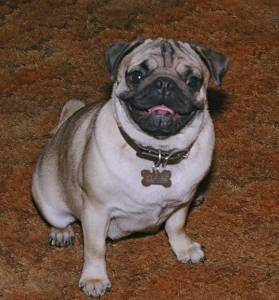

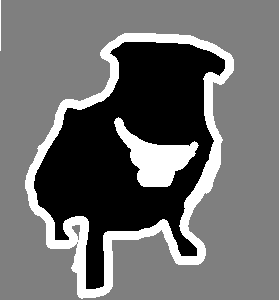

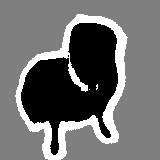

In [8]:
# Generate predictions for all images in the validation set

val_gen = OxfordPets(batch_size, img_size, val_input_img_paths, val_target_img_paths)
val_preds = model.predict(val_gen)


def display_mask(i):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(val_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
    display(img)


# Display results for validation image #10
i = 10

# Display input image
display(Image(filename=val_input_img_paths[i]))

# Display ground-truth target mask
img = ImageOps.autocontrast(load_img(val_target_img_paths[i]))
display(img)

# Display mask predicted by our model
display_mask(i)  # Note that the model only sees inputs at 150x150.

In [109]:
import cv2
import os

# https://stackoverflow.com/questions/57294609/how-to-generate-a-trimap-image
# https://www.robots.ox.ac.uk/~vgg/publications/2012/parkhi12a/parkhi12a.pdf

def generate_trimap(mask_path,eroision_iter=6,dilate_iter=8):
    mask =  mask_path
    img_basename = os.path.basename(mask_path)
    mask = cv2.imread(mask,0)
    print(np.unique(mask))
    mask[mask==38] = 255
    d_kernel = np.ones((3,3))
    erode  = cv2.erode(mask,d_kernel,iterations=eroision_iter)
    dilate = cv2.dilate(mask,d_kernel,iterations=dilate_iter)
    unknown1 = cv2.bitwise_xor(erode,mask)
    unknown2 = cv2.bitwise_xor(dilate,mask)
    unknowns = cv2.add(unknown1,unknown2)
    unknowns[unknowns==255]=127
    trimap = cv2.add(mask,unknowns)
    #cv2.imwrite("mask.png",mask)
    #cv2.imwrite("dilate.png",dilate)
    #cv2.imwrite("tri.png",trimap)
    labels = trimap.copy()
    print(np.unique(labels))
    labels[trimap==127]=3 #2 unknown
    labels[trimap==255]=1 #foreground
    
    labels[trimap==0]=2 #foreground

    print(np.unique(labels))
    ##labels[labels==2]=3
    #labels[labels==1]=1
    ##labels[labels==0]=2
    ##print(np.unique(labels))

    cv2.imwrite(os.path.join("/content/annotations2", img_basename), labels)
    return labels

In [115]:
#mask_path = "/content/images2/Abyssinian_1.png"
mask_path = "/content/images2/yorkshire_terrier_192.png"
x = generate_trimap(mask_path)

[ 0 38]
[  0 127 255]
[1 2 3]


In [116]:
np.unique(x)

array([1, 2, 3], dtype=uint8)

In [117]:
# Display ground-truth target mask
#img = ImageOps.autocontrast(load_img("/content/tri.png"))
#print(np.unique(img))
#display(img)

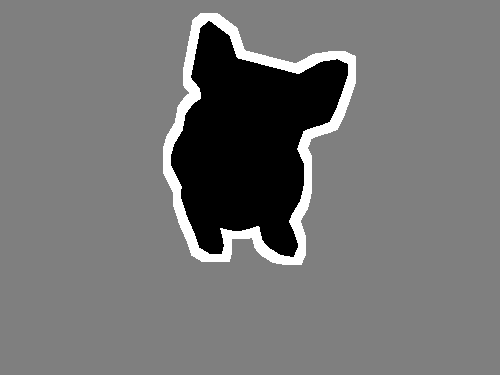

In [118]:
# Display ground-truth target mask
target_basename = os.path.basename(mask_path)
target_path = os.path.join("/content/annotations2", target_basename)
img = ImageOps.autocontrast(load_img(target_path))
display(img)

In [93]:
print(np.min(img), np.max(img), np.unique(img))

0 255 [  0 127 255]


In [28]:
x.min()

0

In [29]:
np.unique(x)

array([ 0, 38, 76], dtype=uint8)

In [30]:
xx = cv2.imread(mask_path)

In [31]:
np.unique(xx)

array([  0, 128], dtype=uint8)

1/1 [==============================] - 0s 41ms/step


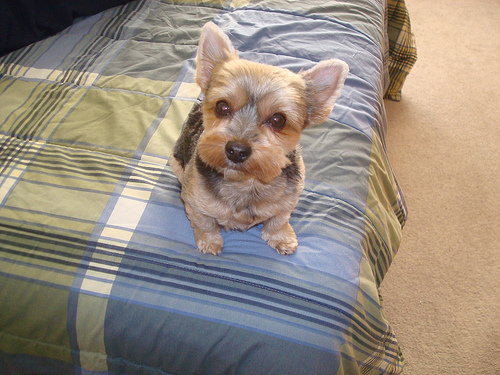

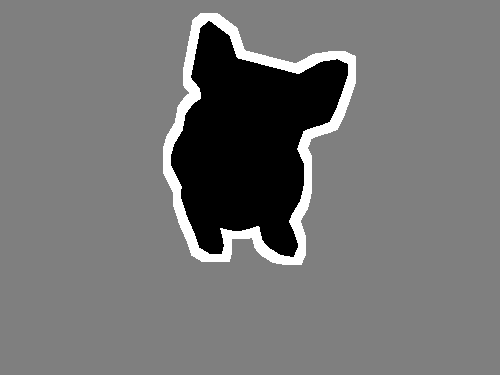

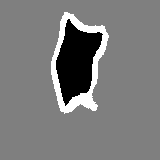

In [125]:
batch_size2 = 1
img_size2 = (160,160)
val_input_img_paths2 = ["/content/images/yorkshire_terrier_192.jpg"]
val_target_img_paths2 = ["/content/images/yorkshire_terrier_192.jpg"]

val_gen2 = OxfordPets(batch_size2, img_size2, val_input_img_paths2, val_target_img_paths2)
val_preds2 = model.predict(val_gen2)

def display_mask2(i):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(val_preds2[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
    display(img)

# Display results for validation image #10
i = 0

# Display input image
display(Image(filename=val_input_img_paths2[i]))

val_target_img_paths2 = [target_path]
# Display ground-truth target mask
img = ImageOps.autocontrast(load_img(val_target_img_paths2[i]))
display(img)

# Display mask predicted by our model
display_mask2(i)  # Note that the model only sees inputs at 150x150.

[  0 127 255]


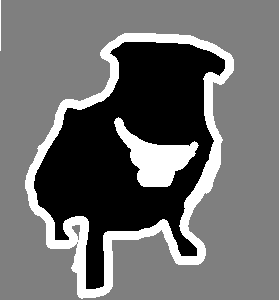

In [32]:
# Display ground-truth target mask
img = ImageOps.autocontrast(load_img(val_target_img_paths[i]))
print(np.unique(img))
display(img)

In [33]:
yy = cv2.imread(val_target_img_paths[i])
np.unique(yy)

array([1, 2, 3], dtype=uint8)

In [ ]:
https://www.kaggle.com/datasets/mateuszbuda/lgg-mri-segmentation
https://www.kaggle.com/code/bonhart/brain-mri-data-visualization-unet-fpn
https://www.kaggle.com/code/monkira/brain-mri-segmentation-using-unet-keras
ok
https://www.kaggle.com/code/monkira/brain-mri-segmentation-using-unet-keras
dataset
https://www.kaggle.com/datasets/mateuszbuda/lgg-mri-segmentation
oki
https://github.com/niranjanbsubramanian/Brain-MRI-Segmentation
https://aiaspirant.com/image-segmentation-brain-mri-segmentation/
o
https://www.epfl.ch/labs/cvlab/data/data-em/
https://www.epfl.ch/labs/cvlab/data/data-em/
https://github.com/bnsreenu/python_for_microscopists
mitocondria segmentation
https://github.com/bnsreenu/python_for_microscopists/blob/master/205_predict_unet_with_watershed_single_image.py


…or create a new repository on the command line
echo "# segmentation" >> README.md
git init
git add README.md
git commit -m "first commit"
git branch -M main
git remote add origin git@github.com:juancasi/segmentation.git
git push -u origin main

…or push an existing repository from the command line
git remote add origin git@github.com:juancasi/segmentation.git
git branch -M main
git push -u origin main

…or import code from another repository
You can initialize this repository with code from a Subversion, Mercurial, or TFS project.




https://www.youtube.com/watch?v=csFGTLT6_WQ
https://github.com/bnsreenu/python_for_microscopists/blob/master/204_train_simple_unet_for_mitochondria.py


https://www.robots.ox.ac.uk/~vgg/data/pets/

https://app.cvat.ai/projects?page=1
